# Practice session on Neural Networks
### 1st COMCHA School

#### Veronics Sanz (University of Sussex, Alan Turing Institute and Valencia )
##### held at Universitat Ramon Llull, October 3rd, 2019


Make sure you have conda and jupyter installed

In [8]:
import sys
!{sys.executable} -m conda install tensorflow matplotlib ipykernel scikit-learn pandas numpy==1.16.4 --yes


Solving environment: done

# All requested packages already installed.



In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# bigger fonts
plt.rcParams['font.size'] = 18

In [11]:
# check that we have the devices we expect available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 277391378063986750]

### Import keras bits and pieces from tensorflow

In [12]:
# if you have a recent version of tensorflow, keras is included
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

### Standard dataset: MNIST handwritten digits

![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png "MNIST")



In [13]:
# the data, split between train and test sets
(x_train, y_train), (x_valtest, y_valtest) = mnist.load_data()

In [ ]:
# demo the effect of noisy data
#x_train = (x_train/5 + np.random.poisson(200, size=x_train.shape)).clip(0, 255)
#x_valtest = (x_valtest/5 + np.random.poisson(200, size=x_valtest.shape)).clip(0, 255)

In [ ]:
# if we wanted to test our model on limited data,
# we could reduce the amount of training data like this...
#idx = np.random.choice(len(x_train), size=len(x_train)//100)
#x_train = x_train[idx]
#y_train = y_train[idx]

### Usually, one splits the data between training, test and validation

#### Training Dataset: 
The sample of data used to fit the model
#### Validation Dataset: 
The sample of data used to provide an unbiased evaluation of a model fit, we use this data to fine-tune the model hyperparameters 
#### Test Dataset:
The sample of data used to provide an unbiased evaluation of a final model fit 


So it is useful to learn how to split the data (using sklearn)

![split](https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png "split")

In [14]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest, test_size=0.5)

In [15]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [16]:
x_test.shape, y_test.shape

((5000, 28, 28), (5000,))

In [17]:
x_val.shape, y_val.shape

((5000, 28, 28), (5000,))

### Take a look at the data

You should always carefully examine any new dataset
This dataset is already curated, but in real-life situations you will spend **a lot of time** trimming and preparing the data

class = 1


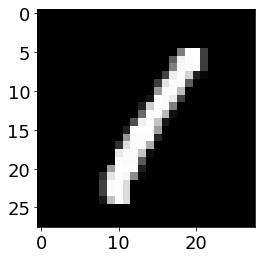

In [18]:
i = 3
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])


class = 8


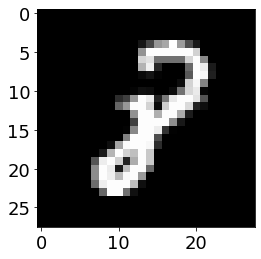

In [19]:
i = 4139
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])

### Prepare the data

Remember the y variables (outputs) are in classes from 0 to 9, e.g. y in the previous plot is class = 8

**One-hot** changes this simple number (class) to a matrix which contains 0 for all the entries except for 8

This is simply implemented using keras utilities

In [20]:
# convert class vectors to "one-hot" class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [21]:
y_train[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

Now the inputs, the images:

Take the 28X28 bins of images (=784) with levels of gray 0 to 255 and

flatten them in an array and re-scale the content (intensity of gray) from 0 to 1

In [22]:
def process_data(x):
    x = x.reshape(-1, 784)
    x = x.astype('float32')
    x /= 255
    return x

In [23]:
x_train = process_data(x_train)
x_test = process_data(x_test)
x_val = process_data(x_val)

In [24]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

60000 train samples
5000 test samples
5000 validation samples


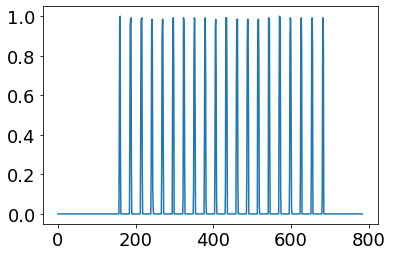

In [25]:
plt.plot(x_train[3])


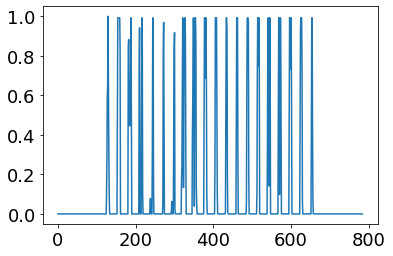

In [26]:
plt.plot(x_train[4139])

## Let's start with a simple NN: fully connected NN

### Build the NN

In [27]:
# Sequential means you can build a DNN layer by layer
fcmodel = Sequential()
# Dense has as arguments: 
#  number of neurons, type of activation function, and the input needs to match the output of the previous layer
#  input_shape=(N_features,) where N_features = 28*28
fcmodel.add(Dense(32, activation='relu', input_shape=(784,)))
# we add a second layer
fcmodel.add(Dense(32, activation='relu'))
# could include dropout, regularisation, ...
fcmodel.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [28]:
fcmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


Next, we choose the loss function according to which we will train the DNN 

For classification problems, this is usually the cross-entropy, and since the output data was cast in categorical
form, we choose the categorical_crossentropy defined in Keras’ losses module 

To optimize the weights of the net, we use SGD and other typical choices are RMSprop or Adam

The parameters for the optimizer, such as lr (learning rate) or momentum are passed using the corresponding optional arguments of the SGD() function

In [29]:
fcmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

### Train the NN

The **batch size** defines the number of samples that will be propagated through the network.

We have 60000 training samples and we set up a batch_size equal to 32. The algorithm takes the first 32 samples from the training dataset and trains the network. Next, it takes the second batch and trains the network again, and keep with this procedure until we have propagated all samples through of the network. 

**Training epochs** defines the number times that the learning algorithm will work through the entire training dataset.


In [30]:
batch_size = 32
epochs = 50

In [34]:
# training the NN
history = fcmodel.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

Train on 60000 samples, validate on 5000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0259 - acc: 0.9936 - val_loss: 0.3847 - val_acc: 0.9624
Epoch 2/50
60000/60000 [==============================] - 9s 146us/sample - loss: 0.0233 - acc: 0.9944 - val_loss: 0.4446 - val_acc: 0.9622
Epoch 3/50
60000/60000 [==============================] - 8s 133us/sample - loss: 0.0243 - acc: 0.9941 - val_loss: 0.4011 - val_acc: 0.9642
Epoch 4/50
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0222 - acc: 0.9947 - val_loss: 0.4264 - val_acc: 0.9632
Epoch 5/50
60000/60000 [==============================] - 8s 131us/sample - loss: 0.0213 - acc: 0.9944 - val_loss: 0.4135 - val_acc: 0.9656
Epoch 6/50
60000/60000 [==============================] - 7s 120us/sample - loss: 0.0222 - acc: 0.9942 - val_loss: 0.4169 - val_acc: 0.9642
Epoch 7/50
60000/60000 [==============================] - 8s 125us/sample - loss: 0.0213 - acc: 0.9943 - val_lo

In [35]:
score = fcmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6123007285869906
Test accuracy: 0.9642


In [36]:
# in principle, we should not look at the score for this set of data
# until we have finished tuning our model
score = fcmodel.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.707311995144169
Test accuracy: 0.9592


In [37]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss', 'val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['acc', 'val_acc'], ax=ax2)
    max_acc = hist['val_acc'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_acc) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

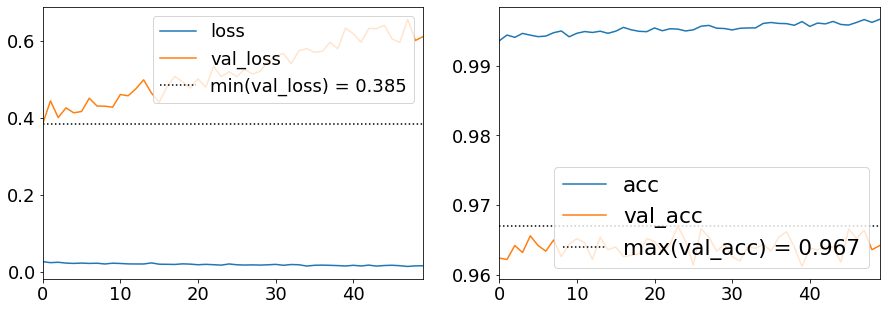

In [38]:
histplot(history)

## Now let's use a Convolutional Neural Network (CNN)

### We need to reshape the data  

In [39]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [40]:
x_train.shape

(60000, 28, 28, 1)

###  Construct the network

In [41]:
# a fairly small network for speed
cnnmodel = Sequential()
cnnmodel.add(Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnnmodel.add(MaxPooling2D((3, 3)))
cnnmodel.add(Conv2D(16, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(num_classes, activation='softmax'))
# could include dropout, regularisation, ...

In [42]:
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [43]:
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1450      
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
____________________________________________________

In [44]:
# save weights for reinitialising below
cnnmodel.save_weights('/tmp/cnnmodel_init_weights.tf')

### Train the CNN

In [45]:
history = cnnmodel.fit(x_train, y_train,
                       batch_size=batch_size, 
                       epochs=3*epochs,
                       verbose=1,
                       validation_data=(x_test, y_test))

Train on 60000 samples, validate on 5000 samples
Epoch 1/150
60000/60000 [==============================] - 15s 255us/sample - loss: 0.3963 - acc: 0.8835 - val_loss: 0.1249 - val_acc: 0.9648
Epoch 2/150
60000/60000 [==============================] - 15s 254us/sample - loss: 0.1238 - acc: 0.9618 - val_loss: 0.0828 - val_acc: 0.9772
Epoch 3/150
60000/60000 [==============================] - 16s 270us/sample - loss: 0.0929 - acc: 0.9715 - val_loss: 0.0670 - val_acc: 0.9804
Epoch 4/150
60000/60000 [==============================] - 14s 228us/sample - loss: 0.0790 - acc: 0.9755 - val_loss: 0.0611 - val_acc: 0.9816
Epoch 5/150
60000/60000 [==============================] - 13s 216us/sample - loss: 0.0700 - acc: 0.9791 - val_loss: 0.0565 - val_acc: 0.9828
Epoch 6/150
60000/60000 [==============================] - 14s 225us/sample - loss: 0.0641 - acc: 0.9808 - val_loss: 0.0478 - val_acc: 0.9824
Epoch 7/150
60000/60000 [==============================] - 13s 212us/sample - loss: 0.0596 - acc: 0

60000/60000 [==============================] - 15s 250us/sample - loss: 0.0240 - acc: 0.9928 - val_loss: 0.0536 - val_acc: 0.9852
Epoch 59/150
60000/60000 [==============================] - 18s 304us/sample - loss: 0.0241 - acc: 0.9926 - val_loss: 0.0558 - val_acc: 0.9854
Epoch 60/150
60000/60000 [==============================] - 13s 217us/sample - loss: 0.0245 - acc: 0.9928 - val_loss: 0.0685 - val_acc: 0.9836
Epoch 61/150
60000/60000 [==============================] - 19s 315us/sample - loss: 0.0237 - acc: 0.9930 - val_loss: 0.0544 - val_acc: 0.9854
Epoch 62/150
60000/60000 [==============================] - 16s 262us/sample - loss: 0.0237 - acc: 0.9928 - val_loss: 0.0546 - val_acc: 0.9838
Epoch 63/150
60000/60000 [==============================] - 13s 218us/sample - loss: 0.0238 - acc: 0.9926 - val_loss: 0.0543 - val_acc: 0.9870
Epoch 64/150
60000/60000 [==============================] - 16s 259us/sample - loss: 0.0239 - acc: 0.9929 - val_loss: 0.0537 - val_acc: 0.9848
Epoch 65/150

60000/60000 [==============================] - 2019s 34ms/sample - loss: 0.0194 - acc: 0.9943 - val_loss: 0.0761 - val_acc: 0.9858
Epoch 116/150
60000/60000 [==============================] - 34s 569us/sample - loss: 0.0186 - acc: 0.9945 - val_loss: 0.0768 - val_acc: 0.9848
Epoch 117/150
60000/60000 [==============================] - 35s 590us/sample - loss: 0.0198 - acc: 0.9943 - val_loss: 0.0774 - val_acc: 0.9864
Epoch 118/150
60000/60000 [==============================] - 32s 536us/sample - loss: 0.0192 - acc: 0.9945 - val_loss: 0.0803 - val_acc: 0.9856
Epoch 119/150
60000/60000 [==============================] - 28s 468us/sample - loss: 0.0196 - acc: 0.9945 - val_loss: 0.0819 - val_acc: 0.9858
Epoch 120/150
60000/60000 [==============================] - 27s 453us/sample - loss: 0.0193 - acc: 0.9945 - val_loss: 0.0789 - val_acc: 0.9860
Epoch 121/150
60000/60000 [==============================] - 27s 456us/sample - loss: 0.0189 - acc: 0.9945 - val_loss: 0.0916 - val_acc: 0.9838
Epoch

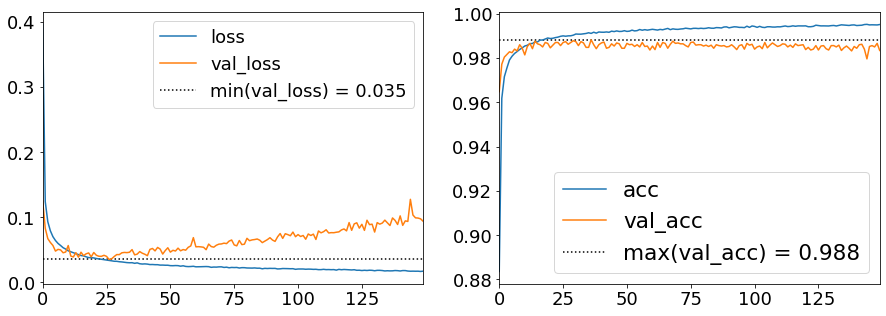

In [46]:
histplot(history)

## Data augmentation

Data augmentation is a technique to artificially create new training data from existing training data by rotating, obscuring or other transformations in the original data. 

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=20.0,
    zoom_range=0.05)

#datagen.fit(x_train)  # only required if normalizing

In [48]:
gen = datagen.flow(x_train, y_train, batch_size=1)

label = 3


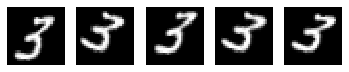

In [49]:
# run this several times to see more augmented examples
i = 3
fig, axarr = plt.subplots(1, 5)
for ax in axarr:
    img = gen[i][0][0, : , :, 0]
    ax.imshow(img, cmap='gray');
    ax.axis('off')
print('label =', gen[i][1][0].argmax())

In [50]:
# Reinitialise model
cnnmodel.load_weights('/tmp/cnnmodel_init_weights.tf')

In [51]:
cnnmodel.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

In [ ]:
# fits the model on batches with real-time data augmentation:
# the accuracy continues to (slowly) rise, due to the augmentation
history = cnnmodel.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                 epochs=10*epochs,
                                 verbose=1,
                                 validation_data=(x_test, y_test))

Epoch 1/500
1875/1875 [==============================] - 113s 60ms/step - loss: 0.5836 - acc: 0.8212 - val_loss: 0.1226 - val_acc: 0.9644
Epoch 2/500
1875/1875 [==============================] - 142s 76ms/step - loss: 0.2315 - acc: 0.9279 - val_loss: 0.0832 - val_acc: 0.9734
Epoch 3/500
1875/1875 [==============================] - 142s 76ms/step - loss: 0.1837 - acc: 0.9432 - val_loss: 0.0738 - val_acc: 0.9756
Epoch 4/500
1875/1875 [==============================] - 151s 81ms/step - loss: 0.1563 - acc: 0.9524 - val_loss: 0.0656 - val_acc: 0.9776
Epoch 5/500
1875/1875 [==============================] - 191s 102ms/step - loss: 0.1397 - acc: 0.9573 - val_loss: 0.0481 - val_acc: 0.9836
Epoch 6/500
1875/1875 [==============================] - 11340s 6s/step - loss: 0.1311 - acc: 0.9590 - val_loss: 0.0516 - val_acc: 0.9818
Epoch 7/500
1875/1875 [==============================] - 74s 40ms/step - loss: 0.1225 - acc: 0.9629 - val_loss: 0.0523 - val_acc: 0.9832
Epoch 8/500
1875/1875 [===========

In [ ]:
histplot(history)